In [1]:
!pip install transformers seqeval -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/work

/content/drive/MyDrive/work


In [4]:
!pip install accelerate -U

In [5]:
!pip install transformers[torch]

In [6]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.1 MB/s eta 0:00:00


In [7]:
from utils import get_params, get_vocab
import pandas as pd
import numpy as np

from transformers import BertTokenizer, BertConfig
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from transformers import BertForTokenClassification, AdamW

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [8]:
vocab, tag_map = get_vocab('data/large/words.txt', 'data/large/tags.txt')
t_sentences, t_labels, t_size = get_params(vocab, tag_map, 'data/large/train/sentences.txt', 'data/large/train/labels.txt')
v_sentences, v_labels, v_size = get_params(vocab, tag_map, 'data/large/val/sentences.txt', 'data/large/val/labels.txt')
test_sentences, test_labels, test_size = get_params(vocab, tag_map, 'data/large/test/sentences.txt', 'data/large/test/labels.txt')

In [9]:
data = pd.read_csv("data/ner_dataset.csv", encoding = "ISO-8859-1")
train_sents = open('data/small/train/sentences.txt', 'r').readline()
train_labels = open('data/small/train/labels.txt', 'r').readline()
print('SENTENCE:', train_sents)
print('SENTENCE LABEL:', train_labels)

SENTENCE: Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .

SENTENCE LABEL: O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O



In [10]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [11]:
data = data.fillna(method='ffill')

In [13]:
entities_to_remove = ["B-gpe","I-gpe","B-art", "I-art", "B-eve", "I-eve", "B-nat", "I-nat"]
data = data[~data.Tag.isin(entities_to_remove)]
data =data.drop(['POS'],axis=1)
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [14]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [15]:
class GetSentence(object):
    def __init__(self,data):
        self.data = data
        self.n_sentences = 1
        self.empty = False
        agg_function = lambda s: [(w,t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.group = self.data.groupby('Sentence #').apply(agg_function)
        self.sentence = [s for s in self.group]

In [16]:
getter = GetSentence(data)

In [17]:
sentence = [[word[0] for word in sentence] for sentence in getter.sentence]

In [18]:
sentence[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [19]:
labels = [[lab[1] for lab in sentence] for sentence in getter.sentence]

In [20]:
labels[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [21]:
tag_values = list(set(data["Tag"].values))

In [22]:
tag_values

['B-org', 'B-per', 'I-tim', 'O', 'I-per', 'I-org', 'I-geo', 'B-tim', 'B-geo']

In [23]:
tag_values.append('PAD')

In [24]:
tag_idx = {t: i for i, t in enumerate(tag_values)}

In [25]:
tag_idx

{'B-org': 0,
 'B-per': 1,
 'I-tim': 2,
 'O': 3,
 'I-per': 4,
 'I-org': 5,
 'I-geo': 6,
 'B-tim': 7,
 'B-geo': 8,
 'PAD': 9}

In [26]:
torch.__version__

'2.0.1+cu118'

In [27]:
MAX_LEN = 75
BATCH_SIZE = 16

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
print(torch.cuda.device_count())

1


In [32]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case = False)

In [33]:
def tokenize_preserve(sentences,text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentences,text_labels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label]*n_subwords)

    return tokenized_sentence, labels


In [34]:
tokenized_texts_and_labels = [
  tokenize_preserve(sent,labs)
  for sent,labs in zip(sentence,labels)
]

In [35]:
tokenized_text = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1]for token_label_pair in tokenized_texts_and_labels]

In [36]:
len(tokenized_text[0]) , len(labels[0])

(25, 25)

In [37]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_text],
                         maxlen=MAX_LEN, dtype='long',value=0.0,
                         truncating='post',padding='post')

In [38]:
tags = pad_sequences([[tag_idx.get(l)for l in lab]for lab in labels],
                    maxlen=MAX_LEN, dtype='long', value=tag_idx['PAD'],
                    truncating='post',padding='post')

In [39]:
attention_masks = [[float(i !=0.0)for i in ii]for ii in input_ids]

In [40]:
tr_input, val_input, tr_tag, val_tag = train_test_split(input_ids,tags,random_state=45,test_size=.1)

In [41]:
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=45, test_size=.1)

In [42]:
len(tr_masks[0]),len(tr_input[0]), len(tr_tag[0])
print(tr_masks[0]), print(tr_input[0]), print(tr_tag[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[10000  2110  4108 19496  1335  5971  1183  1163  1175  1108  1185  6281
  5088  1106 12010   119     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
[3 3 1 1 4 4 4 3 3 3 3 3 3 3 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9]


(None, None, None)

In [43]:
tr_input = torch.tensor(tr_input)
val_input = torch.tensor(val_input)
tr_tag = torch.tensor(tr_tag)
val_tag = torch.tensor(val_tag)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [44]:
train_data = TensorDataset(tr_input, tr_masks, tr_tag)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(tr_input, tr_masks, tr_tag)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [45]:
model = BertForTokenClassification.from_pretrained(
'bert-base-cased',
num_labels=len(tag_idx),
output_attentions = False,
output_hidden_states = False)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
# model.cuda()

In [47]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
from transformers import get_linear_schedule_with_warmup

epochs = 5
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [49]:
!pip install seqeval

In [50]:
from seqeval.metrics import f1_score, accuracy_score

In [51]:
from tqdm import tqdm, trange

In [52]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [54]:
#storing loss values
loss_values, validation_loss_values = [], []

#TRAINING AND VALIDATION

for _ in trange(epochs, desc= "Epoch"):
    #/|\==>TRAINLOOP(ONEPASS)<==\|/
    model.train()
    total_loss=0 #so it resets each epoch

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch #also the order in train_data/val_data

        model.zero_grad() #clearing previous gradients for each epoch

        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask, labels=b_labels)#forward pass

        loss = outputs[0]
        loss.backward() #getting the loss and performing backward pass

        total_loss += loss.item() #tracking loss

        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        #^^^ preventing exploding grads

        optimizer.step() #updates parameters

        scheduler.step() #update learning_rate

    avg_train_loss = total_loss/len(train_dataloader)
    print('Average train loss : {}'.format(avg_train_loss))

    loss_values.append(avg_train_loss) #storing loss values if you choose to plot learning curve

    #/|\==>VALIDATION(ONEPASS)<==\|/
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions, true_labels = [], []

    for batch in valid_dataloader:
        batch = tuple(t.to(device)for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids =None,
                           attention_mask=b_input_mask, labels=b_labels)

        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)
    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print('Validation loss: {}'.format(eval_loss))

    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                for p_i, l_i, in zip(p,l)if tag_values[l_i] !='PAD']

    valid_tags = [tag_values[l_i]for l in true_labels
                 for l_i in l if tag_values[l_i] !='PAD']

    print('Validation Accuracy: {}'.format(accuracy_score(pred_tags,valid_tags)))
    print('Validation F-1 Score:{}'.format(f1_score([pred_tags], [valid_tags])))




Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Average train loss : 0.04372900202155826
Validation loss: 0.028565741746347767
Validation Accuracy: 0.9710566306475038


Epoch:  20%|██        | 1/5 [13:19<53:18, 799.60s/it]

Validation F-1 Score:0.8511705558717511
Average train loss : 0.02947210380401921
Validation loss: 0.018357474341215943
Validation Accuracy: 0.9805146983231556


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Epoch:  40%|████      | 2/5 [26:31<39:44, 794.89s/it]

Validation F-1 Score:0.8956596548127508
Average train loss : 0.019704665914273684
Validation loss: 0.010685831150462025
Validation Accuracy: 0.9886680760309013


Epoch:  60%|██████    | 3/5 [39:45<26:29, 794.56s/it]

Validation F-1 Score:0.9349778424172461
Average train loss : 0.013065156477393536
Validation loss: 0.006914301351783038
Validation Accuracy: 0.9929980392266815


Epoch:  80%|████████  | 4/5 [52:59<13:14, 794.34s/it]

Validation F-1 Score:0.9583127671216104
Average train loss : 0.009071549763999674
Validation loss: 0.0054110836270578
Validation Accuracy: 0.9947999319617266


Epoch: 100%|██████████| 5/5 [1:06:14<00:00, 794.90s/it]

Validation F-1 Score:0.9682004465241459


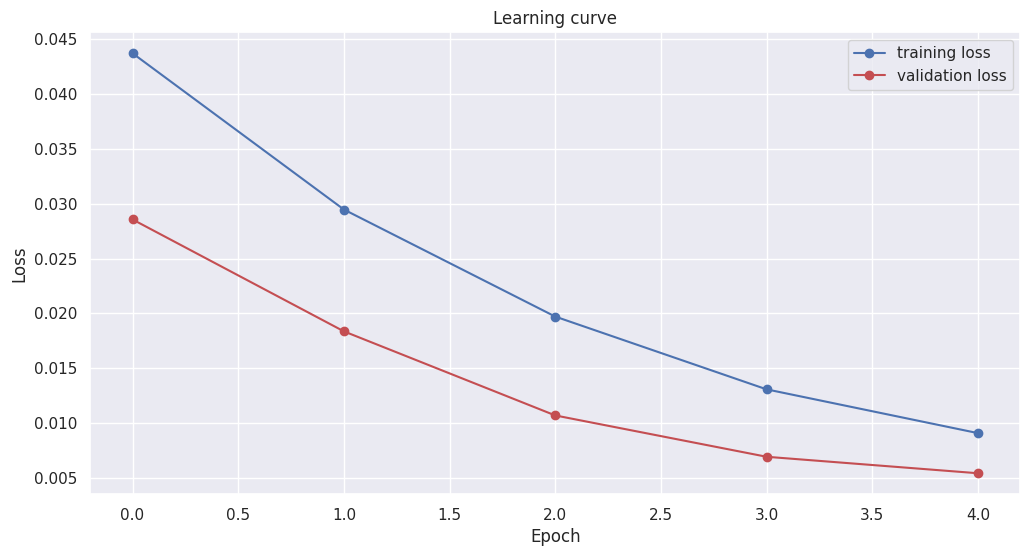

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

plt.rcParams['figure.figsize'] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [267]:
## Save model
import os
PATH = os.getcwd()+ "/ner_model_pretrained_bert.pt"
TOKENIZER_PATH = os.getcwd() + "/ner_tokenizer"
# model.save_pretrained(PATH)
torch.save(model, PATH)

In [268]:
## Save tokenizer
tokenizer.save_pretrained(TOKENIZER_PATH)

('/content/drive/MyDrive/work/ner_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/work/ner_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/work/ner_tokenizer/vocab.txt',
 '/content/drive/MyDrive/work/ner_tokenizer/added_tokens.json')

In [325]:
device

device(type='cuda')

In [243]:
import json

In [244]:
id2label = {
    str(i): label for i,label in enumerate(tag_values)
}
label2id = {
    label: str(i) for i,label in enumerate(tag_values)
}

In [245]:
config = json.load(open("ner_model_pretrained_bert/config.json"))
config["id2label"] = id2label
config["label2id"] = label2id
json.dump(config, open("ner_model_pretrained_bert/config.json","w"))

In [269]:
# model_fine_tuned = BertForTokenClassification.from_pretrained(PATH)
model_fine_tuned = torch.load(PATH)
model_fine_tuned = model_fine_tuned.to(device)

In [270]:
tokenizer_bert = BertTokenizer.from_pretrained(TOKENIZER_PATH)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [271]:
test_sentence = """Huy and Tuong were running in the forest with their dog yesterday in Da Nang"""

In [272]:
tokenized_sentence = tokenizer_bert.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [250]:
with torch.no_grad():
    output = model_fine_tuned(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(),axis=2)

In [251]:
tokens = tokenizer_bert.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

new_tokens, new_labels = [], []

for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith('##'):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [252]:
names = []
locs = []
orgs = []
tims = []

curr_name = ""
curr_loc = ""
curr_org = ""
curr_tim = ""
for i in range(len(new_tokens)):
    if new_labels[i] != 'O':
        leb = new_labels[i]
        if leb == "B-per":
            if curr_loc != "":
                locs.append(curr_loc)
                curr_loc = ""
            if curr_org != "":
                orgs.append(curr_org)
                curr_org = ""
            if curr_tim != "":
                tims.append(curr_tim)
                curr_tim = ""
            if curr_name != "":
                curr_name += " "
            curr_name += new_tokens[i]


        if leb == "I-per":
            if curr_loc != "":
                locs.append(curr_loc)
                curr_loc = ""
            if curr_org != "":
                orgs.append(curr_org)
                curr_org = ""
            if curr_tim != "":
                tims.append(curr_tim)
                curr_tim = ""
            if curr_name != "":
                curr_name += " "
            curr_name += new_tokens[i]

        if leb == "B-geo":
            if curr_name != "":
                names.append(curr_name)
                curr_name = ""
            if curr_org != "":
                orgs.append(curr_org)
                curr_org = ""
            if curr_tim != "":
                tims.append(curr_tim)
                curr_tim = ""
            if curr_loc != "":
                curr_loc += " "
            curr_loc += new_tokens[i]

        if leb == "I-geo":
            if curr_name != "":
                names.append(curr_name)
                curr_name = ""
            if curr_org != "":
                orgs.append(curr_org)
                curr_org = ""
            if curr_tim != "":
                tims.append(curr_tim)
                curr_tim = ""
            if curr_loc != "":
                curr_loc += " "
            curr_loc += new_tokens[i]

        if leb == "B-org":
            if curr_loc != "":
                locs.append(curr_loc)
                curr_loc = ""
            if curr_name != "":
                names.append(curr_name)
                curr_name = ""
            if curr_tim != "":
                tims.append(curr_tim)
                curr_tim = ""
            if curr_org != "":
                curr_org += " "
            curr_org += new_tokens[i]



        if leb == "I-org":
            if curr_loc != "":
                locs.append(curr_loc)
                curr_loc = ""
            if curr_name != "":
                names.append(curr_name)
                curr_name = ""
            if curr_tim != "":
                tims.append(curr_tim)
                curr_tim = ""
            if curr_org != "":
                curr_org += " "
            curr_org += new_tokens[i]

        if leb == "B-tim":
            if curr_loc != "":
                locs.append(curr_loc)
                curr_loc = ""
            if curr_name != "":
                names.append(curr_name)
                curr_name = ""
            if curr_org != "":
                locs.append(curr_org)
                curr_org = ""
            if curr_tim != "":
                curr_tim += " "
            curr_tim += new_tokens[i]

        if leb == "I-tim":
            if curr_loc != "":
                locs.append(curr_loc)
                curr_loc = ""
            if curr_name != "":
                names.append(curr_name)
                curr_name = ""
            if curr_org != "":
                locs.append(curr_org)
                curr_org = ""
            if curr_tim != "":
                curr_tim += " "
            curr_tim += new_tokens[i]

    else:
        if curr_name != "":
            names.append(curr_name)
            curr_name = ""
        if curr_loc != "":
            locs.append(curr_loc)
            curr_loc = ""
        if curr_org != "":
            orgs.append(curr_org)
            curr_org = ""
        if curr_tim != "":
            tims.append(curr_tim)
            curr_tim = ""



df = pd.DataFrame()
df["Free flow of Text"] = [test_sentence]
df["Extracted Name"] = [names]
df["Extracted Location"] = [locs]
df["Extracted Organization"] = [orgs]
df["Extracted Time"] = [tims]

print(df)

df.to_csv("output1.csv", index=False)

                                   Free flow of Text Extracted Name  \
0  Huy and Tuong were running in the forest with ...   [Huy, Tuong]   

  Extracted Location Extracted Organization Extracted Time  
0          [Da Nang]                     []    [yesterday]  


In [253]:
df

,Free flow of Text,Extracted Name,Extracted Location,Extracted Organization,Extracted Time
0,Huy and Tuong were running in the forest with ...,"[Huy, Tuong]",[Da Nang],[],[yesterday]


In [254]:
# !pip install parsedatetime

In [255]:
df["Extracted Time"][0][0]

'yesterday'

In [256]:
from datetime import datetime
import parsedatetime

cal = parsedatetime.Calendar()
time_struct, parse_status = cal.parse(df["Extracted Time"][0][0])
datetime(*time_struct[:6])

datetime.datetime(2023, 10, 12, 9, 0)

In [365]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)